https://archive.ics.uci.edu/dataset/20/census+income 

Predict if income exceeds $50,000 per year based on census data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
col_names = ['age', 'workclass', 'fnlwgt','education', 'education-num', 
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain','capital-loss', 'hours-per-week','native-country', 'income']


df = pd.read_csv('adult.data', header=None, names = col_names)

In [5]:
df

age          workclass  fnlwgt    education  education-num  \
0       39          State-gov   77516    Bachelors             13   
1       50   Self-emp-not-inc   83311    Bachelors             13   
2       38            Private  215646      HS-grad              9   
3       53            Private  234721         11th              7   
4       28            Private  338409    Bachelors             13   
...    ...                ...     ...          ...            ...   
32556   27            Private  257302   Assoc-acdm             12   
32557   40            Private  154374      HS-grad              9   
32558   58            Private  151910      HS-grad              9   
32559   22            Private  201490      HS-grad              9   
32560   52       Self-emp-inc  287927      HS-grad              9   

            marital-status          occupation    relationship    race  \
0            Never-married        Adm-clerical   Not-in-family   White   
1       Married-civ-spouse     Exec-managerial         Husband   White   
2                 Divorced   Handlers-cleaners   Not-in-family   White   
3       Married-civ-spouse   Handlers-cleaners         Husband   Black   
4       Married-civ-spouse      Prof-specialty            Wife   Black   
...                    ...                 ...             ...     ...   
32556   Married-civ-spouse        Tech-support            Wife   White   
32557   Married-civ-spouse   Machine-op-inspct         Husband   White   
32558              Widowed        Adm-clerical       Unmarried   White   
32559        Never-married        Adm-clerical       Own-child   White   
32560   Married-civ-spouse     Exec-managerial            Wife   White   

           sex  capital-gain  capital-loss  hours-per-week  native-country  \
0         Male          2174             0              40   United-States   
1         Male             0             0              13   United-States   
2         Male             0             0              40   United-States   
3         Male             0             0              40   United-States   
4       Female             0             0              40            Cuba   
...        ...           ...           ...             ...             ...   
32556   Female             0             0              38   United-States   
32557     Male             0             0              40   United-States   
32558   Female             0             0              40   United-States   
32559     Male             0             0              20   United-States   
32560   Female         15024             0              40   United-States   

       income  
0       <=50K  
1       <=50K  
2       <=50K  
3       <=50K  
4       <=50K  
...       ...  
32556   <=50K  
32557    >50K  
32558   <=50K  
32559   <=50K  
32560    >50K  

[32561 rows x 15 columns]

In [6]:
#Distribution of income
print(df.income.value_counts(normalize=True))

#Clean columns by stripping extra whitespace for columns of type "object"
for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].str.strip()
    

feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex','race']
#Create feature dataframe X with feature columns and dummy variables for categorical features
X = pd.get_dummies(df[feature_cols], drop_first=True)
#Create output variable y which is binary, 0 when income is less than 50k, 1 when it is greather than 50k
y = np.where(df.income=='<=50K', 0, 1)

#Split data into a train and test set
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

#Instantiate random forest classifier, fit and score with default parameters
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf.score(x_test, y_test)
print(f'Accuracy score for default random forest: {round(rf.score(x_test, y_test)*100,3)}%')

income
 <=50K    0.75919
 >50K     0.24081
Name: proportion, dtype: float64
Accuracy score for default random forest: 81.79%


The highest accuracy on the test is achieved when depth: 12
The highest accuracy on the test set is: 83.464%


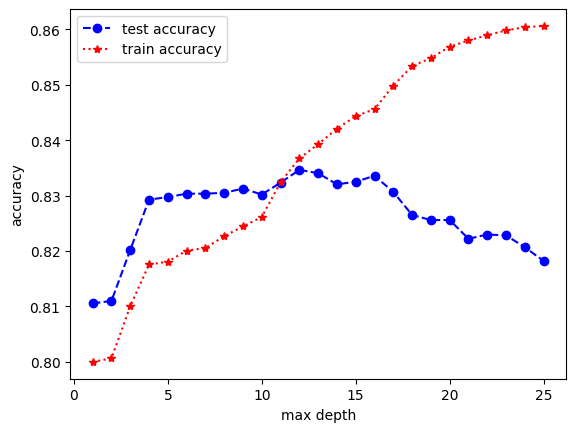

In [7]:
#Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
accuracy_train=[]
accuracy_test = []
depths = range(1,26)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(x_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))
    
#Find the best accuracy and at what depth that occurs
best_acc= np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

#Plot the accuracy scores for the test and train set over the range of depth values  
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')

plt.show()

In [8]:
#Save the best random forest model and save the feature importances in a dataframe
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(x_train, y_train)
feature_imp_df = pd.DataFrame(zip(x_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])


#Create two new features, based on education and native country
df['education_bin'] = pd.cut(df['education-num'], [0,9,13,16], labels=['HS or less', 'College to Bachelors', 'Masters or more'])

feature_cols = ['age',
       'capital-gain', 'capital-loss', 'hours-per-week', 'sex', 'race','education_bin']
#Use these two new additional features and recreate X and test/train split
X = pd.get_dummies(df[feature_cols], drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(X,y, random_state=1, test_size=.2)

Top 5 random forest features:
          feature  importance
1    capital-gain    0.370119
0             age    0.248969
3  hours-per-week    0.140480
2    capital-loss    0.140439
4        sex_Male    0.078258


The highest accuracy on the test is achieved when depth: 9
The highest accuracy on the test set is: 84.431%


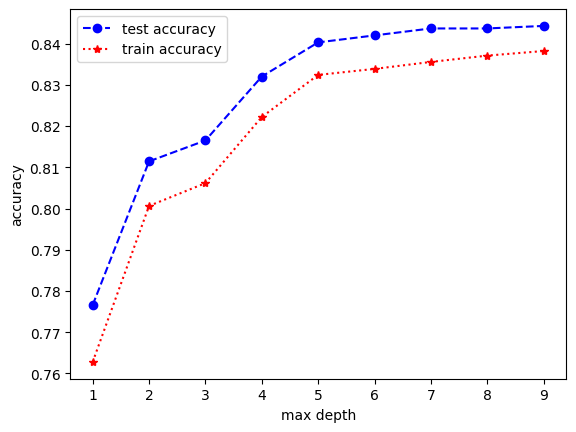

In [9]:
#Find the best max depth now with the additional two features
np.random.seed(0)
accuracy_train=[]
accuracy_test = []
depths = range(1,10)
for i in depths:
    rf = RandomForestClassifier(max_depth=i)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)
    accuracy_test.append(accuracy_score(y_test, rf.predict(x_test)))
    accuracy_train.append(accuracy_score(y_train, rf.predict(x_train)))
    
best_acc= np.max(accuracy_test)
best_depth = depths[np.argmax(accuracy_test)]
print(f'The highest accuracy on the test is achieved when depth: {best_depth}')
print(f'The highest accuracy on the test set is: {round(best_acc*100,3)}%')

plt.figure(2)
plt.plot(depths, accuracy_test,'bo--',depths, accuracy_train,'r*:')
plt.legend(['test accuracy', 'train accuracy'])
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.show()

In [10]:
#Save the best model and print the two features with the new feature set
best_rf = RandomForestClassifier(max_depth=best_depth)
best_rf.fit(x_train, y_train)
feature_imp_df = pd.DataFrame(zip(x_train.columns, best_rf.feature_importances_),  columns=['feature', 'importance'])
print('Top 5 random forest features:')
print(feature_imp_df.sort_values('importance', ascending=False).iloc[0:5])

Top 5 random forest features:
                          feature  importance
1                    capital-gain    0.326836
0                             age    0.201973
10  education_bin_Masters or more    0.130849
3                  hours-per-week    0.102162
2                    capital-loss    0.095188
